In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

In [2]:
from tensorflow.keras.models import Model

def visualize_layer_outputs(model, image, n):
    """
    Pass an image through the first `n` layers of the model and plot output channels.

    Parameters:
    - model: Keras Sequential model
    - image: single input image (shape must match model input)
    - n: number of layers to include
    """
    # Ensure image has batch dimension
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)

    # Create a model up to the nth layer
    truncated_model = Model(inputs=model.input, outputs=model.layers[n].output)

    # Get activations
    activations = truncated_model.predict(image)
    
    # Squeeze batch dimension if needed
    if activations.ndim == 4:
        activations = np.squeeze(activations, axis=0)  # shape: (H, W, C)

    n_channels = activations.shape[-1]

    # Set up subplot grid
    n_cols = 4
    n_rows = int(np.ceil((n_channels + 1) / n_cols))  # +1 for original image
    size = 4
    
    plt.figure(figsize=(size * n_cols, size * n_rows))

    # Plot original image
    plt.subplot(n_rows, n_cols, 1)
    if image.shape[-1] == 1:
        plt.imshow(image[0, ..., 0], cmap='gray')
    else:
        plt.imshow(image[0])
    plt.title("Original")
    plt.axis('off')

    # Plot each channel
    for i in range(n_channels):
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(activations[..., i], cmap='gray', interpolation=None)
        plt.title(f"Channel {i}")

    plt.tight_layout()
    plt.show()

# Keras CNN on un-augmented CIFAR10 data

In [3]:
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (50000, 32, 32, 3)
X_test.shape:  (10000, 32, 32, 3)


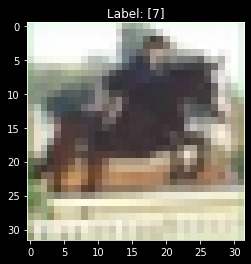

In [4]:
# Display a random image
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx])
plt.title(f"Label: {y_train[idx]}")
plt.show()

## Create/train/analyze model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

dropout_rate = 0.1

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),
    Dropout(dropout_rate),
    
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(16, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 8)        32        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 16)        

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay

# define training parameters
epochs          = 50
batch_size      = 256
decay_epochs    = int( epochs * 1 )

n_train         = X_train.shape[0]
steps_per_epoch = int( np.ceil( n_train / batch_size ) )
decay_steps     = decay_epochs * steps_per_epoch

# Define the learning rate schedule
initial_learning_rate = 0.01

optimizer = Adam(
    learning_rate=initial_learning_rate,
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
196/196 [==============================] - 9s 39ms/step - loss: 1.7135 - accuracy: 0.3479 - val_loss: 1.7676 - val_accuracy: 0.3386
Epoch 2/50
196/196 [==============================] - 7s 38ms/step - loss: 1.4202 - accuracy: 0.4708 - val_loss: 1.4684 - val_accuracy: 0.4654
Epoch 3/50
196/196 [==============================] - 7s 38ms/step - loss: 1.2708 - accuracy: 0.5392 - val_loss: 1.2770 - val_accuracy: 0.5417
Epoch 4/50
196/196 [==============================] - 8s 38ms/step - loss: 1.1934 - accuracy: 0.5735 - val_loss: 1.4439 - val_accuracy: 0.5052
Epoch 5/50
196/196 [==============================] - 7s 38ms/step - loss: 1.1257 - accuracy: 0.6015 - val_loss: 1.0208 - val_accuracy: 0.6410
Epoch 6/50
196/196 [==============================] - 8s 38ms/step - loss: 1.0784 - accuracy: 0.6180 - val_loss: 1.0281 - val_accuracy: 0.6397
Epoch 7/50
196/196 [==============================] - 8s 38ms/step - loss: 1.0472 - accuracy: 0.6306 - val_loss: 0.9473 - val_accuracy: 0.6735

313/313 [==============================] - 1s 3ms/step


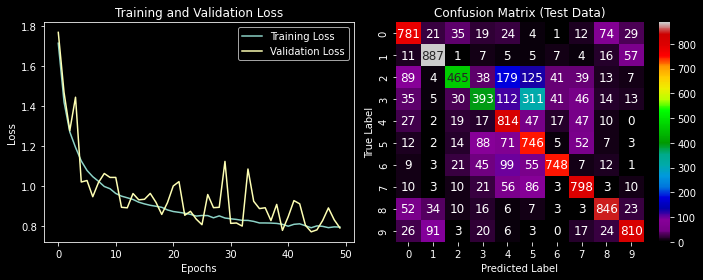

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.84      0.89      0.86      1000
           2       0.76      0.47      0.58      1000
           3       0.59      0.39      0.47      1000
           4       0.59      0.81      0.69      1000
           5       0.54      0.75      0.62      1000
           6       0.86      0.75      0.80      1000
           7       0.78      0.80      0.79      1000
           8       0.83      0.85      0.84      1000
           9       0.85      0.81      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.72     10000
weighted avg       0.74      0.73      0.72     10000



In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Visualize channels after processing

In [17]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or any image shaped like your input

1/1 [==============================] - 0s 27ms/step


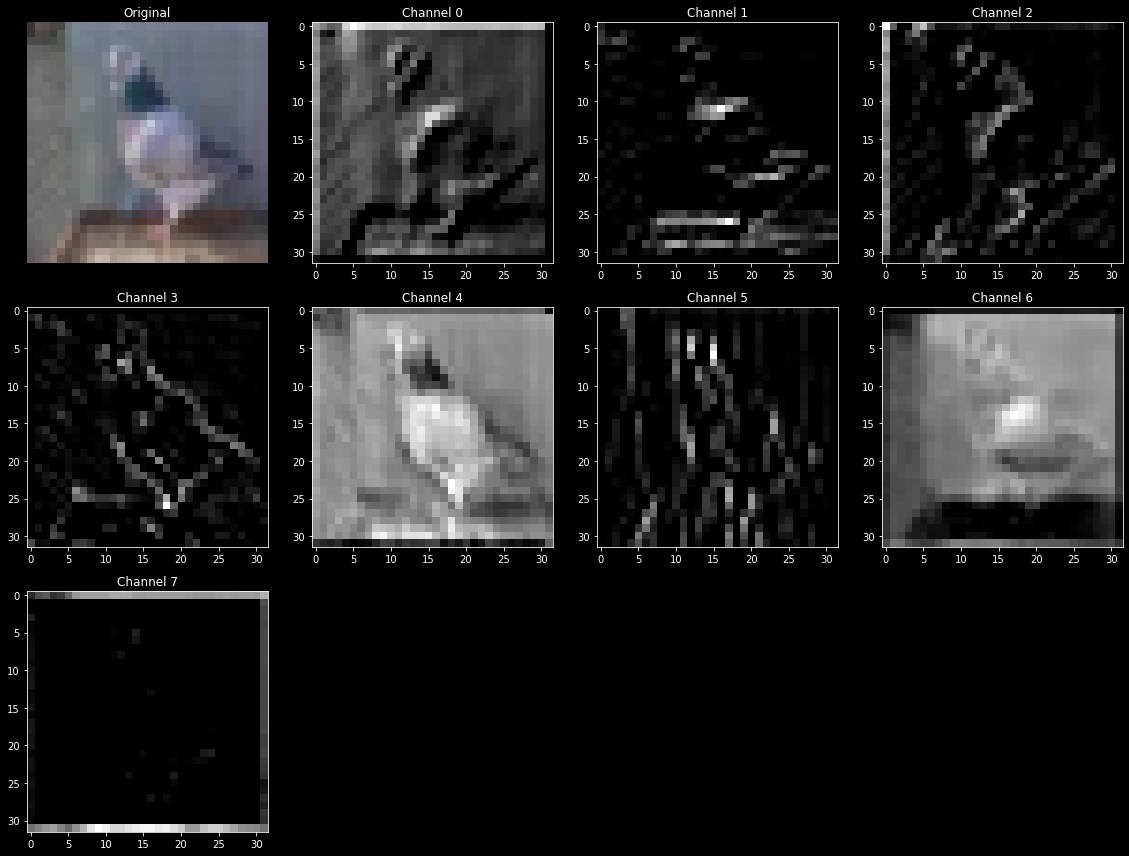

In [18]:
# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=0)